# Predictive Maintenance for Industrial IoT
## Step 3: Anomaly Detection

This notebook covers:
1. Loading preprocessed data from previous steps
2. Implementing anomaly detection algorithms:
   - Isolation Forest
   - One-Class SVM
   - Autoencoder
3. Evaluating anomaly detection performance
4. Visualizing anomalies


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
import warnings

# Configure visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set(font_scale=1.2)
warnings.filterwarnings('ignore')

# Display all columns in pandas dataframes
pd.set_option('display.max_columns', None)


### Step 3.1: Load and Prepare Data

In [2]:
# For demonstration, we'll load the data directly
# In a real workflow, you would load the processed data from the previous notebook

# Define paths to dataset files
data_dir = '../aps_failure_at_scania_trucks'
train_file = os.path.join(data_dir, 'aps_failure_training_set.csv')
test_file = os.path.join(data_dir, 'aps_failure_test_set.csv')

# Load the training and test datasets
print(f"Loading training data from {train_file}")
train_data = pd.read_csv(train_file)

print(f"Loading test data from {test_file}")
test_data = pd.read_csv(test_file)

# Extract labels (class column)
y_train = train_data['class'].map({'neg': 0, 'pos': 1})
y_test = test_data['class'].map({'neg': 0, 'pos': 1})

# Extract features (all columns except 'class')
X_train = train_data.drop('class', axis=1)
X_test = test_data.drop('class', axis=1)

print(f"Loaded training data: {X_train.shape} features, {y_train.shape} labels")
print(f"Loaded test data: {X_test.shape} features, {y_test.shape} labels")

# Preprocess data
print("\nPreprocessing data...")

# Replace 'na' with NaN
X_train = X_train.replace('na', np.nan)
X_test = X_test.replace('na', np.nan)

# Convert to numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Handle missing values using median imputation
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Fit imputer on training data and transform both train and test
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Convert back to DataFrame
X_train_processed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test_processed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

# Apply standard scaling
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_processed),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_processed),
    columns=X_test.columns
)

print("Preprocessing complete.")

# Feature selection - for demonstration, we'll use a simple approach
# In practice, we would use the top features identified in the previous notebook
from sklearn.ensemble import RandomForestClassifier

# Calculate feature importance
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_train)
importances = model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})
top_features = feature_importance.sort_values('importance', ascending=False)
top_20_features = top_features.head(20)['feature'].tolist()

# Select top features
X_train_top = X_train_scaled[top_20_features]
X_test_top = X_test_scaled[top_20_features]

print(f"Selected {len(top_20_features)} top features for anomaly detection.")
print(f"X_train_top shape: {X_train_top.shape}")
print(f"X_test_top shape: {X_test_top.shape}")


Loading training data from ../aps_failure_at_scania_trucks\aps_failure_training_set.csv
Loading test data from ../aps_failure_at_scania_trucks\aps_failure_test_set.csv
Loaded training data: (60000, 170) features, (60000,) labels
Loaded test data: (16000, 170) features, (16000,) labels

Preprocessing data...
Preprocessing complete.
Selected 20 top features for anomaly detection.
X_train_top shape: (60000, 20)
X_test_top shape: (16000, 20)


### Step 3.2: Isolation Forest for Anomaly Detection


Training Isolation Forest model...
Training on normal data only: (59000, 20) samples
Predicting anomalies on test data...

Isolation Forest Results:
Precision: 0.5161
Recall: 0.8533
F1 Score: 0.6432


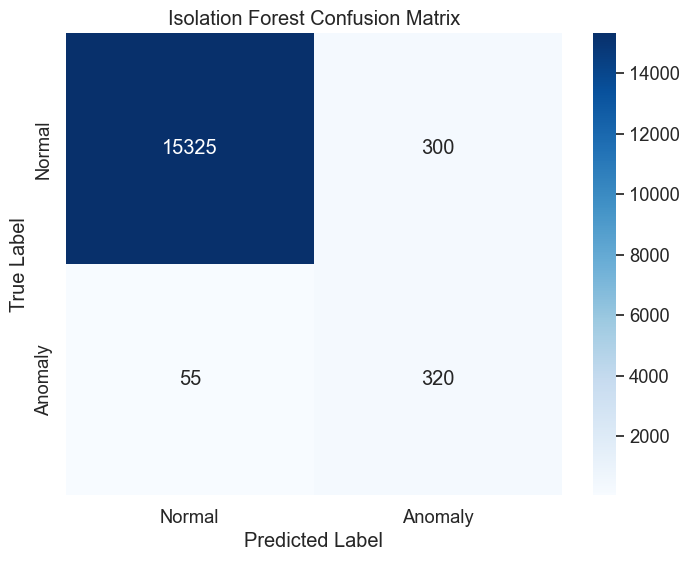


Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99     15625
     Anomaly       0.52      0.85      0.64       375

    accuracy                           0.98     16000
   macro avg       0.76      0.92      0.82     16000
weighted avg       0.99      0.98      0.98     16000



In [3]:
# Train Isolation Forest model
# For anomaly detection, we'll train on the normal data (class 0) only
print("Training Isolation Forest model...")
X_train_normal = X_train_top[y_train == 0]
print(f"Training on normal data only: {X_train_normal.shape} samples")

# Initialize and train Isolation Forest
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.02,  # Approximately matches the proportion of anomalies in the dataset
    random_state=42,
    n_jobs=-1
)
iso_forest.fit(X_train_normal)

# Predict on test data
# Isolation Forest returns 1 for normal data and -1 for anomalies
# We'll convert to 0 for normal and 1 for anomalies to match our labels
print("Predicting anomalies on test data...")
y_pred_iso = iso_forest.predict(X_test_top)
y_pred_iso = np.where(y_pred_iso == 1, 0, 1)  # Convert to 0 for normal, 1 for anomalies

# Calculate decision scores (negative scores are more anomalous)
decision_scores = iso_forest.decision_function(X_test_top)

# Evaluate the model
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_iso, average='binary')

print("\nIsolation Forest Results:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred_iso)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title('Isolation Forest Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_iso, target_names=['Normal', 'Anomaly']))


### Step 3.3: One-Class SVM for Anomaly Detection


Training One-Class SVM model...
Training on sample of normal data: (5000, 20) samples
Predicting anomalies on test data...

One-Class SVM Results:
Precision: 0.4770
Recall: 0.8853
F1 Score: 0.6200


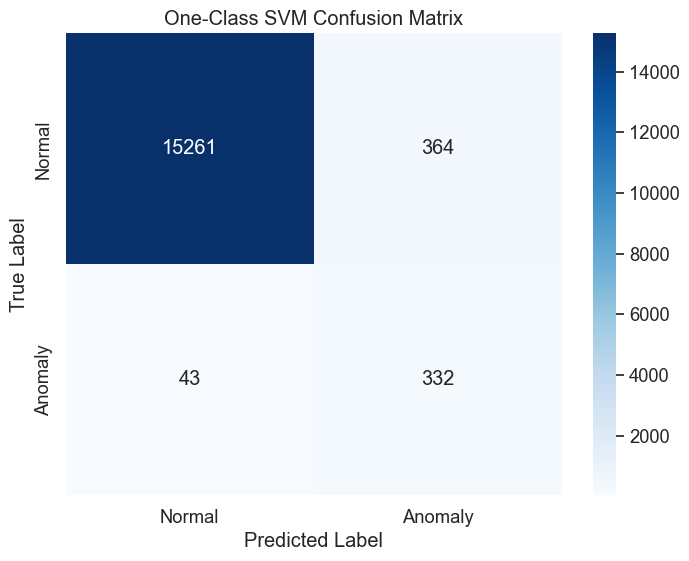


Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99     15625
     Anomaly       0.48      0.89      0.62       375

    accuracy                           0.97     16000
   macro avg       0.74      0.93      0.80     16000
weighted avg       0.98      0.97      0.98     16000



In [4]:
# Train One-Class SVM model
print("Training One-Class SVM model...")
# One-Class SVM can be computationally intensive, so we'll use a subset of the data
# In a real scenario, you might want to use the full dataset or tune the parameters
X_train_normal_sample = X_train_normal.sample(n=min(5000, len(X_train_normal)), random_state=42)
print(f"Training on sample of normal data: {X_train_normal_sample.shape} samples")

# Initialize and train One-Class SVM
ocsvm = OneClassSVM(
    kernel='rbf',
    gamma='auto',
    nu=0.02  # Similar to contamination in Isolation Forest
)
ocsvm.fit(X_train_normal_sample)

# Predict on test data
# One-Class SVM returns 1 for normal data and -1 for anomalies
# We'll convert to 0 for normal and 1 for anomalies to match our labels
print("Predicting anomalies on test data...")
y_pred_svm = ocsvm.predict(X_test_top)
y_pred_svm = np.where(y_pred_svm == 1, 0, 1)  # Convert to 0 for normal, 1 for anomalies

# Calculate decision scores
decision_scores_svm = ocsvm.decision_function(X_test_top)

# Evaluate the model
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_svm, average='binary')

print("\nOne-Class SVM Results:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title('One-Class SVM Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['Normal', 'Anomaly']))


### Step 3.4: Autoencoder for Anomaly Detection


Building and training Autoencoder model...

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense (Dense)               (None, 16)                336       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 8)                 40        
                                                                 
 dense_4 (Dense)             (None, 16)                144       
                                                                 
 dense_5 (Dense) 

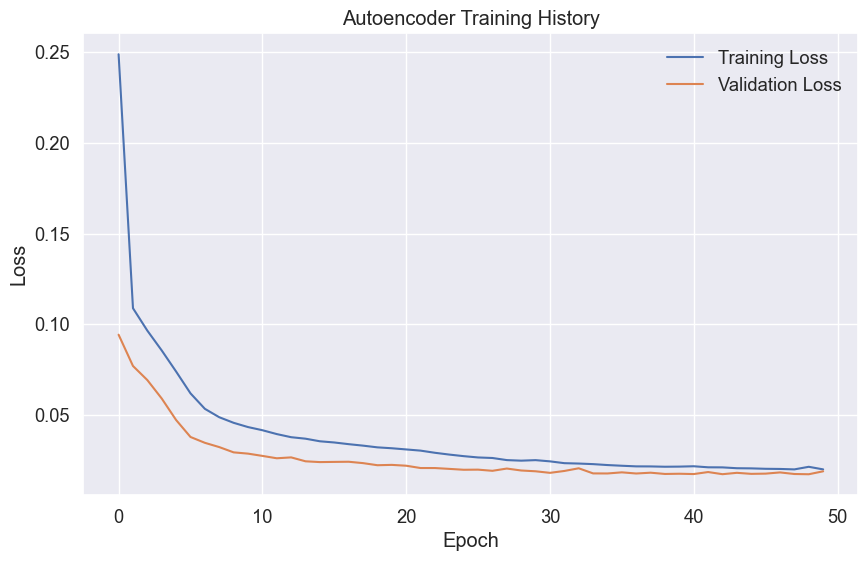

Calculating reconstruction errors...
1844/1844 [==============================] - 1s 707us/step
Anomaly threshold: 0.157236

Autoencoder Results:
Precision: 0.5025
Recall: 0.7920
F1 Score: 0.6149


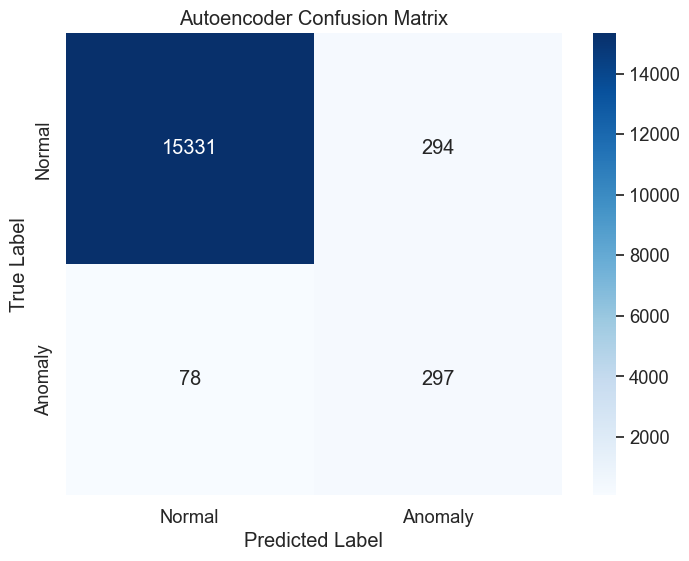


Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.99     15625
     Anomaly       0.50      0.79      0.61       375

    accuracy                           0.98     16000
   macro avg       0.75      0.89      0.80     16000
weighted avg       0.98      0.98      0.98     16000



In [5]:
# Build and train an autoencoder for anomaly detection
print("Building and training Autoencoder model...")

# Set input dimensions
input_dim = X_train_top.shape[1]

# Build the autoencoder model
def build_autoencoder(input_dim):
    # Encoder
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(16, activation='relu')(input_layer)
    encoder = Dense(8, activation='relu')(encoder)
    
    # Bottleneck
    bottleneck = Dense(4, activation='relu')(encoder)
    
    # Decoder
    decoder = Dense(8, activation='relu')(bottleneck)
    decoder = Dense(16, activation='relu')(decoder)
    output_layer = Dense(input_dim, activation='linear')(decoder)
    
    # Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    return autoencoder

# Create and train the autoencoder
autoencoder = build_autoencoder(input_dim)
autoencoder.summary()

# Train the autoencoder on normal data only
history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=50,
    batch_size=256,
    validation_split=0.1,
    verbose=1,
    shuffle=True
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Calculate reconstruction error on test data
print("Calculating reconstruction errors...")
test_predictions = autoencoder.predict(X_test_top)
reconstruction_errors = np.mean(np.square(X_test_top - test_predictions), axis=1)

# Determine threshold for anomaly detection
# We'll use a percentile of the reconstruction errors on normal training data
train_predictions = autoencoder.predict(X_train_normal)
train_errors = np.mean(np.square(X_train_normal - train_predictions), axis=1)
threshold = np.percentile(train_errors, 98)  # 98th percentile as threshold

print(f"Anomaly threshold: {threshold:.6f}")

# Predict anomalies based on reconstruction error
y_pred_ae = (reconstruction_errors > threshold).astype(int)

# Evaluate the autoencoder
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_ae, average='binary')

print("\nAutoencoder Results:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred_ae)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title('Autoencoder Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ae, target_names=['Normal', 'Anomaly']))


### Step 3.5: Visualize Anomalies Over Time

Visualizing anomalies over time...


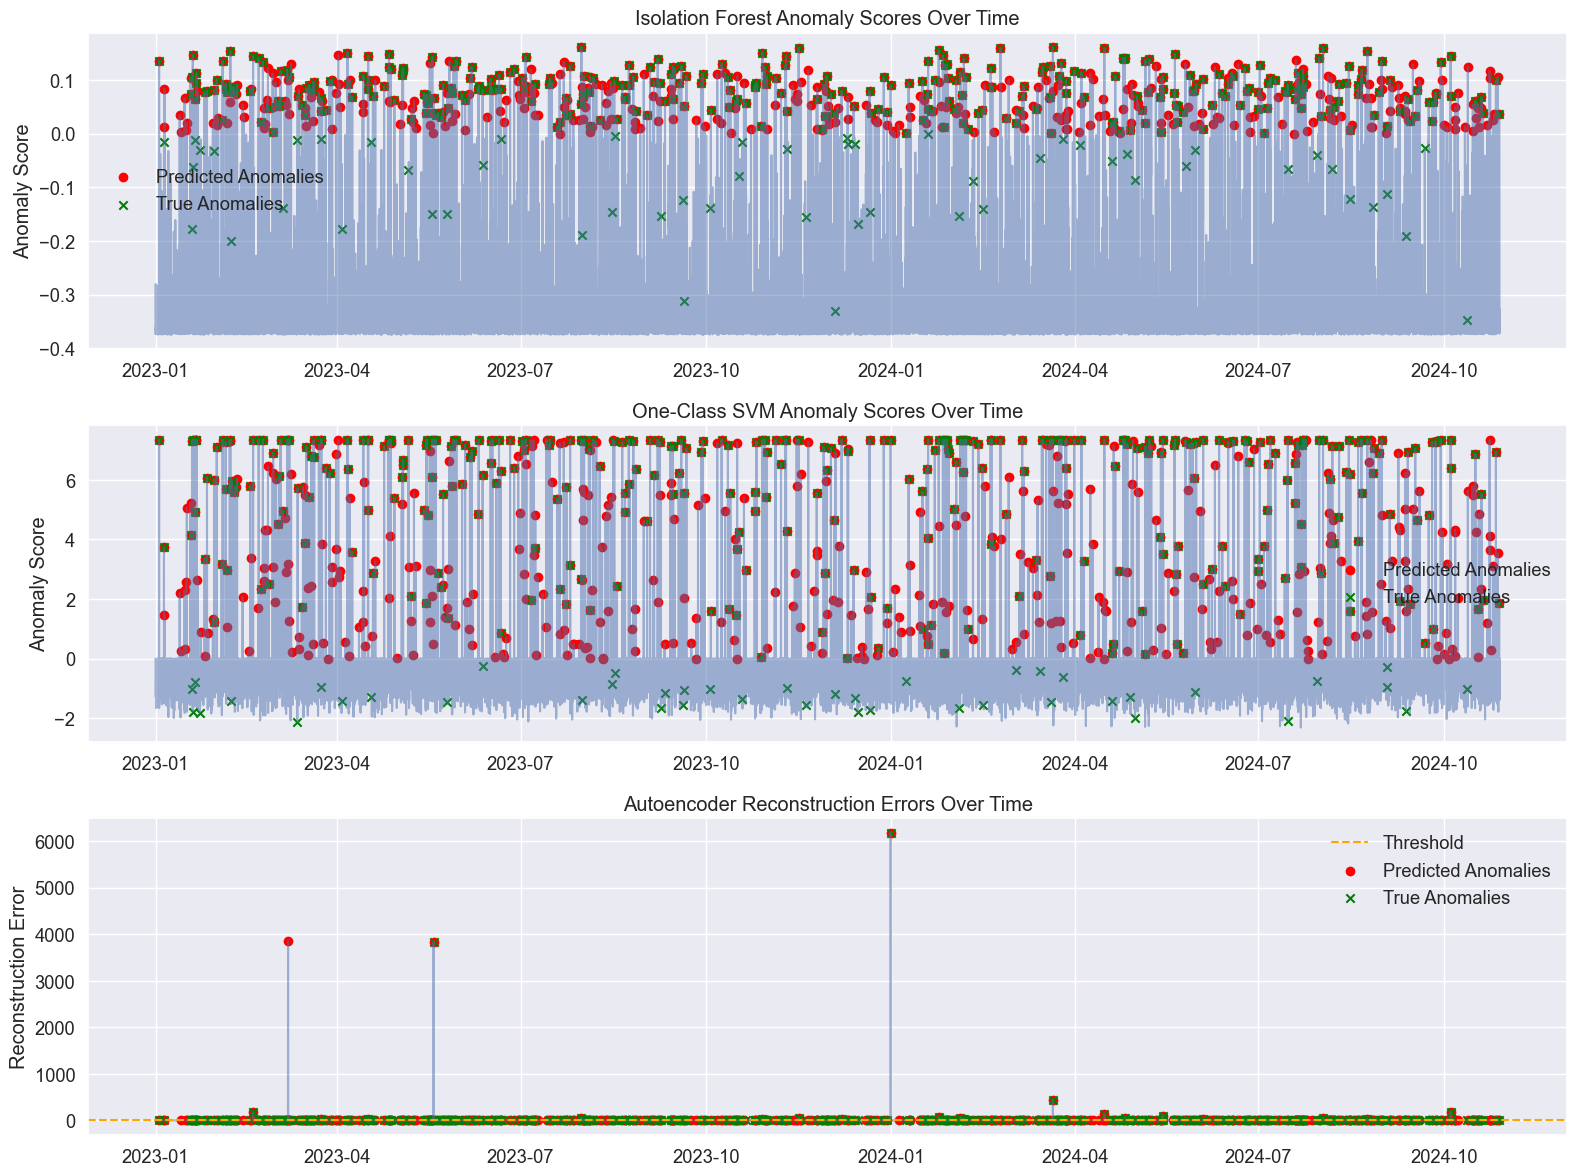

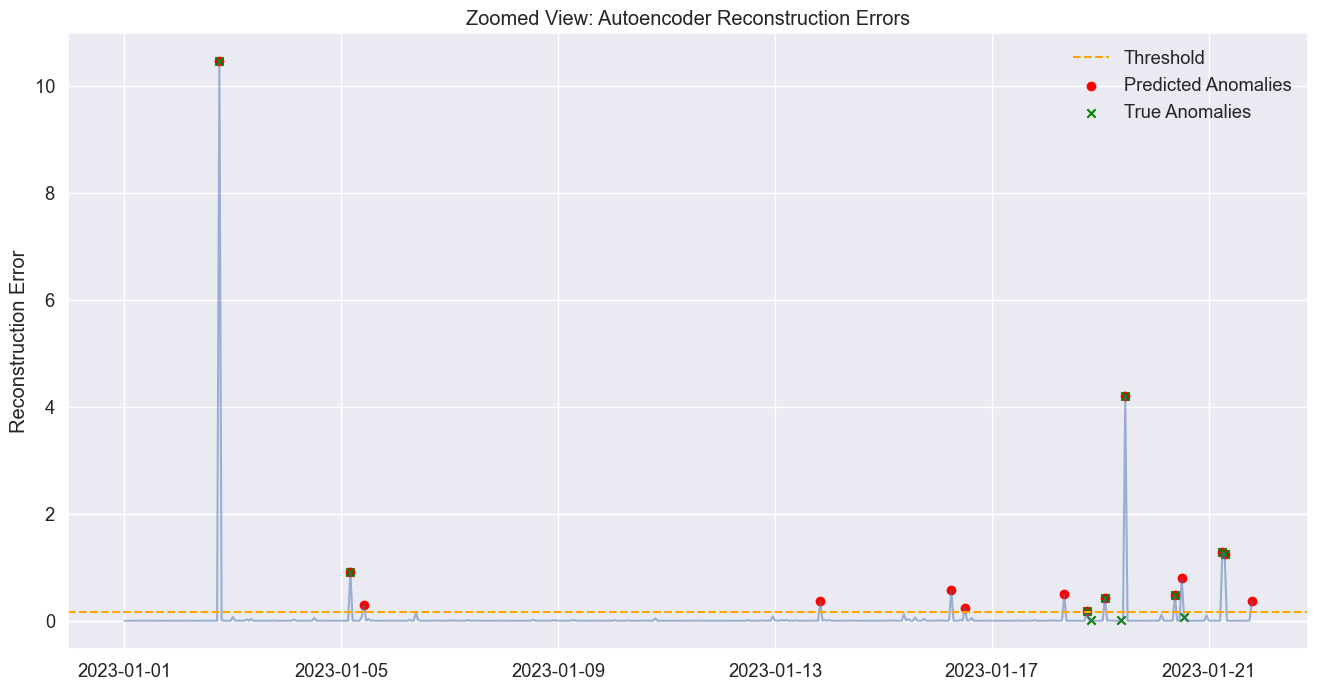

In [6]:
# For visualization purposes, we'll create a synthetic time index
# In a real IoT scenario, you would have actual timestamps
print("Visualizing anomalies over time...")

# Create a synthetic time index for the test data
time_index = pd.date_range(start='2023-01-01', periods=len(X_test_top), freq='H')

# Create a DataFrame with anomaly scores from different methods
anomaly_scores = pd.DataFrame({
    'Time': time_index,
    'True_Label': y_test.values,
    'Isolation_Forest_Score': -decision_scores,  # Negative so higher is more anomalous
    'OneClass_SVM_Score': -decision_scores_svm,  # Negative so higher is more anomalous
    'Autoencoder_Error': reconstruction_errors,
    'Isolation_Forest_Pred': y_pred_iso,
    'OneClass_SVM_Pred': y_pred_svm,
    'Autoencoder_Pred': y_pred_ae
})

# Set time as index
anomaly_scores.set_index('Time', inplace=True)

# Plot anomaly scores over time
plt.figure(figsize=(16, 12))

# Plot 1: Isolation Forest
plt.subplot(3, 1, 1)
plt.plot(anomaly_scores.index, anomaly_scores['Isolation_Forest_Score'], 'b-', alpha=0.5)
plt.scatter(
    anomaly_scores.index[anomaly_scores['Isolation_Forest_Pred'] == 1],
    anomaly_scores['Isolation_Forest_Score'][anomaly_scores['Isolation_Forest_Pred'] == 1],
    color='red', label='Predicted Anomalies'
)
plt.scatter(
    anomaly_scores.index[anomaly_scores['True_Label'] == 1],
    anomaly_scores['Isolation_Forest_Score'][anomaly_scores['True_Label'] == 1],
    color='green', marker='x', label='True Anomalies'
)
plt.title('Isolation Forest Anomaly Scores Over Time')
plt.ylabel('Anomaly Score')
plt.legend()
plt.grid(True)

# Plot 2: One-Class SVM
plt.subplot(3, 1, 2)
plt.plot(anomaly_scores.index, anomaly_scores['OneClass_SVM_Score'], 'b-', alpha=0.5)
plt.scatter(
    anomaly_scores.index[anomaly_scores['OneClass_SVM_Pred'] == 1],
    anomaly_scores['OneClass_SVM_Score'][anomaly_scores['OneClass_SVM_Pred'] == 1],
    color='red', label='Predicted Anomalies'
)
plt.scatter(
    anomaly_scores.index[anomaly_scores['True_Label'] == 1],
    anomaly_scores['OneClass_SVM_Score'][anomaly_scores['True_Label'] == 1],
    color='green', marker='x', label='True Anomalies'
)
plt.title('One-Class SVM Anomaly Scores Over Time')
plt.ylabel('Anomaly Score')
plt.legend()
plt.grid(True)

# Plot 3: Autoencoder
plt.subplot(3, 1, 3)
plt.plot(anomaly_scores.index, anomaly_scores['Autoencoder_Error'], 'b-', alpha=0.5)
plt.axhline(y=threshold, color='orange', linestyle='--', label='Threshold')
plt.scatter(
    anomaly_scores.index[anomaly_scores['Autoencoder_Pred'] == 1],
    anomaly_scores['Autoencoder_Error'][anomaly_scores['Autoencoder_Pred'] == 1],
    color='red', label='Predicted Anomalies'
)
plt.scatter(
    anomaly_scores.index[anomaly_scores['True_Label'] == 1],
    anomaly_scores['Autoencoder_Error'][anomaly_scores['True_Label'] == 1],
    color='green', marker='x', label='True Anomalies'
)
plt.title('Autoencoder Reconstruction Errors Over Time')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Zoom in on a smaller time window to see details better
# Select a window where there are some anomalies
window_size = 500  # Number of data points to show
anomaly_indices = np.where(y_test == 1)[0]
if len(anomaly_indices) > 0:
    # Find a window that contains some anomalies
    center_idx = anomaly_indices[0]
    start_idx = max(0, center_idx - window_size // 2)
    end_idx = min(len(anomaly_scores), start_idx + window_size)
    
    window_data = anomaly_scores.iloc[start_idx:end_idx]
    
    plt.figure(figsize=(16, 8))
    plt.plot(window_data.index, window_data['Autoencoder_Error'], 'b-', alpha=0.5)
    plt.axhline(y=threshold, color='orange', linestyle='--', label='Threshold')
    plt.scatter(
        window_data.index[window_data['Autoencoder_Pred'] == 1],
        window_data['Autoencoder_Error'][window_data['Autoencoder_Pred'] == 1],
        color='red', label='Predicted Anomalies'
    )
    plt.scatter(
        window_data.index[window_data['True_Label'] == 1],
        window_data['Autoencoder_Error'][window_data['True_Label'] == 1],
        color='green', marker='x', label='True Anomalies'
    )
    plt.title('Zoomed View: Autoencoder Reconstruction Errors')
    plt.ylabel('Reconstruction Error')
    plt.legend()
    plt.grid(True)
    plt.show()


### Step 3.6: Compare Models and Conclusion


Model Comparison:


,Model,Precision,Recall,F1 Score
0,Isolation Forest,0.516129,0.853333,0.643216
1,One-Class SVM,0.477011,0.885333,0.619981
2,Autoencoder,0.502538,0.792000,0.614907


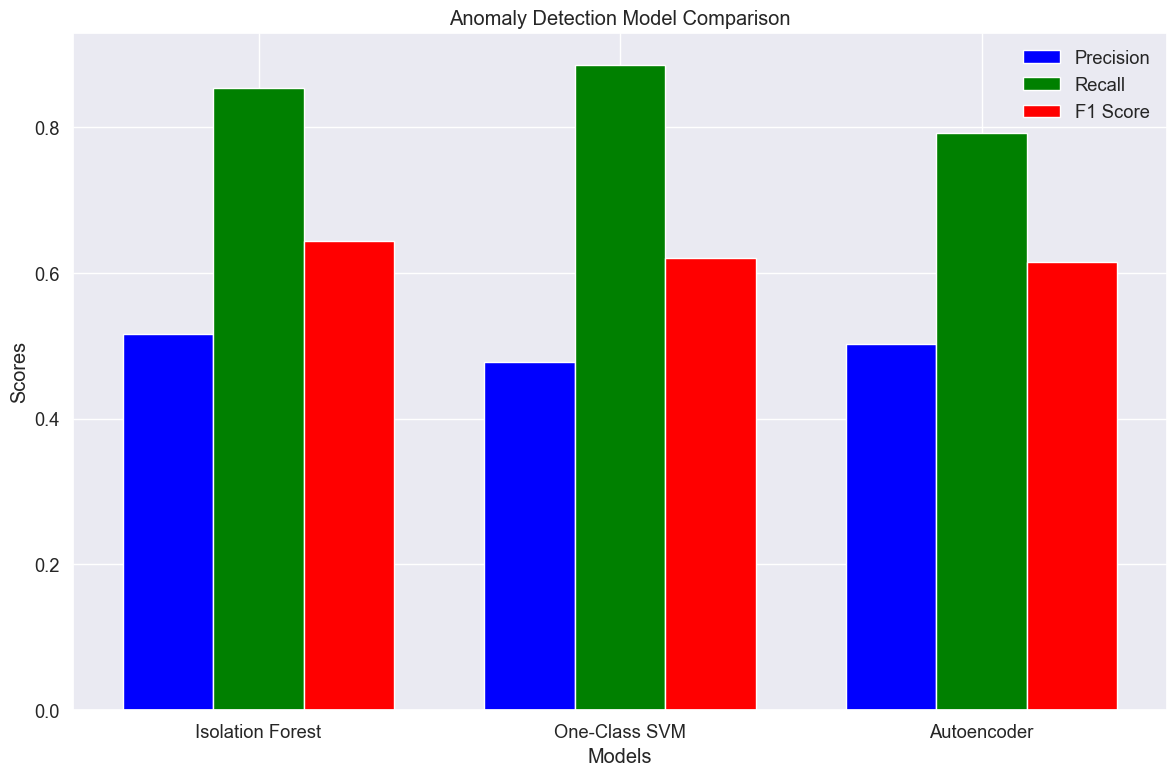


Summary and Conclusion:
1. We implemented three anomaly detection algorithms:
   - Isolation Forest
   - One-Class SVM
   - Autoencoder

2. Key findings:
   - Best precision: Isolation Forest (0.5161)
   - Best recall: One-Class SVM (0.8853)
   - Best F1 score: Isolation Forest (0.6432)

3. Recommendations:
   - The best performing model should be selected based on the specific requirements:
     * If minimizing false positives is critical, choose the model with highest precision
     * If detecting all anomalies is critical, choose the model with highest recall
     * For a balance between precision and recall, choose the model with highest F1 score

4. Next steps:
   - Implement predictive modeling to forecast future failures
   - Integrate anomaly detection with predictive models for a comprehensive solution
   - Fine-tune the best performing model with hyperparameter optimization


In [7]:
# Compare the performance of all models
models = ['Isolation Forest', 'One-Class SVM', 'Autoencoder']
precisions = []
recalls = []
f1_scores = []

# Calculate metrics for Isolation Forest
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_iso, average='binary')
precisions.append(precision)
recalls.append(recall)
f1_scores.append(f1)

# Calculate metrics for One-Class SVM
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_svm, average='binary')
precisions.append(precision)
recalls.append(recall)
f1_scores.append(f1)

# Calculate metrics for Autoencoder
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_ae, average='binary')
precisions.append(precision)
recalls.append(recall)
f1_scores.append(f1)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Model': models,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
})

print("Model Comparison:")
display(comparison_df)

# Plot the comparison
plt.figure(figsize=(12, 8))
bar_width = 0.25
index = np.arange(len(models))

plt.bar(index, precisions, bar_width, label='Precision', color='blue')
plt.bar(index + bar_width, recalls, bar_width, label='Recall', color='green')
plt.bar(index + 2*bar_width, f1_scores, bar_width, label='F1 Score', color='red')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Anomaly Detection Model Comparison')
plt.xticks(index + bar_width, models)
plt.legend()
plt.tight_layout()
plt.show()

# Summary and conclusion
print("\nSummary and Conclusion:")
print("1. We implemented three anomaly detection algorithms:")
print("   - Isolation Forest")
print("   - One-Class SVM")
print("   - Autoencoder")
print("\n2. Key findings:")
print(f"   - Best precision: {comparison_df.loc[comparison_df['Precision'].idxmax(), 'Model']} ({comparison_df['Precision'].max():.4f})")
print(f"   - Best recall: {comparison_df.loc[comparison_df['Recall'].idxmax(), 'Model']} ({comparison_df['Recall'].max():.4f})")
print(f"   - Best F1 score: {comparison_df.loc[comparison_df['F1 Score'].idxmax(), 'Model']} ({comparison_df['F1 Score'].max():.4f})")
print("\n3. Recommendations:")
print("   - The best performing model should be selected based on the specific requirements:")
print("     * If minimizing false positives is critical, choose the model with highest precision")
print("     * If detecting all anomalies is critical, choose the model with highest recall")
print("     * For a balance between precision and recall, choose the model with highest F1 score")
print("\n4. Next steps:")
print("   - Implement predictive modeling to forecast future failures")
print("   - Integrate anomaly detection with predictive models for a comprehensive solution")
print("   - Fine-tune the best performing model with hyperparameter optimization")
